In [1]:
import numpy as np
import tensorflow as tf
from curriculum_learning.models.classifier_model import ClassifierModel
from curriculum_learning import utils
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import tensorflow_datasets as tfds
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import re
import pandas as pd

In [4]:
N_EPOCHS_CL = 50
N_TRIALS = 50
BATCH_SIZE = 512

model_fit_base_params = {
    "batch_size": BATCH_SIZE,
    "shuffle": True,
    "verbose": 0,
}
model_fit_1_params = model_fit_base_params | {"epochs": 1}
model_fit_500_params = model_fit_base_params | {"epochs": 500}

loss = tf.keras.losses.SparseCategoricalCrossentropy()

In [14]:
x = []
y = []

ds_1 = tfds.load("stl10", split="train", as_supervised=True, shuffle_files=False)
for x_, y_ in ds_1.as_numpy_iterator():
    x.append(x_)
    y.append(y_)
    
ds_2 = tfds.load("stl10", split="test", as_supervised=True, shuffle_files=False)
for x_, y_ in ds_2.as_numpy_iterator():
    x.append(x_)
    y.append(y_)

x = np.array(x, dtype=np.float32) / 255
y = np.array(y, dtype=np.float32)

2024-07-27 11:10:44.971744: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-07-27 11:10:45.736033: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [16]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42, stratify=y)
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.5, random_state=42, stratify=y_test)

n_classes = len(np.unique(y))
train_size = x_train.shape[0]

x_train_sorted = x_train[np.argsort(y_train)]
y_train_sorted = y_train[np.argsort(y_train)]
_, counts = np.unique(y_train_sorted, return_counts=True)

train_size, len(x_val), len(x_test), train_size + len(x_val) + len(x_test)

(9100, 1950, 1950, 13000)

In [17]:
model_edg_fixed = ClassifierModel(output_shape=n_classes, **utils.MODEL_ARCHITECTURE)
model_edg_fixed.compile(optimizer="adam", loss=loss, metrics=["accuracy"])
model_edg_fixed(x_train[0:1])
model_edg_fixed.load_weights(f"../models/best/edges_fixed_eurosat.weights.h5")

/Users/dbugajny/PycharmProjects/CurriculumLearning/venv/lib/python3.9/site-packages/keras/src/saving/saving_lib.py:396: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 38 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


ValueError: A total of 1 objects could not be loaded. Example error message for object <Dense name=dense, built=True>:

Layer 'dense' expected 2 variables, but received 0 variables during loading. Expected: ['kernel', 'bias']

List of objects that could not be loaded:
[<Dense name=dense, built=True>]

In [278]:
model_edg_proba = ClassifierModel(output_shape=n_classes, **utils.MODEL_ARCHITECTURE)
model_edg_proba.compile(optimizer="adam", loss=loss, metrics=["accuracy"])
model_edg_proba(x_train[0:1])
model_edg_proba.load_weights(f"../models/best/edges_proba_eurosat.weights.h5")

/Users/dbugajny/PycharmProjects/CurriculumLearning/venv/lib/python3.9/site-packages/keras/src/saving/saving_lib.py:396: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 38 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


In [279]:
model_los_fixed = ClassifierModel(output_shape=n_classes, **utils.MODEL_ARCHITECTURE)
model_los_fixed.compile(optimizer="adam", loss=loss, metrics=["accuracy"])
model_los_fixed(x_train[0:1])
model_los_fixed.load_weights(f"../models/best/edges_fixed_eurosat.weights.h5")

/Users/dbugajny/PycharmProjects/CurriculumLearning/venv/lib/python3.9/site-packages/keras/src/saving/saving_lib.py:396: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 38 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


In [21]:
model_los_proba = ClassifierModel(output_shape=n_classes, **utils.MODEL_ARCHITECTURE)
model_los_proba.compile(optimizer="adam", loss=loss, metrics=["accuracy"])
model_los_proba(x_train[0:1])
model_los_proba.load_weights(f"../models/best/edges_fixed_stl10.weights.h5")

/Users/dbugajny/PycharmProjects/CurriculumLearning/venv/lib/python3.9/site-packages/keras/src/saving/saving_lib.py:396: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 38 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


In [19]:
model_random = ClassifierModel(output_shape=n_classes, **utils.MODEL_ARCHITECTURE)
model_random.compile(optimizer="adam", loss=loss, metrics=["accuracy"])
model_random(x_train[0:1])
model_random.load_weights(f"../models/best/random_stl10.weights.h5")

In [22]:
sklearn.metrics.accuracy_score(y_test, np.argmax(model_los_proba.predict(x_test), axis=1))

61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


0.6251282051282051

In [282]:
y_test_map = np.vectorize(lbl_rev.get)(y_test)

y_pred_edg_fixed = model_edg_fixed.predict(x_test)
y_pred_edg_fixed = np.argmax(y_pred_edg_fixed, axis=1)
conf_mat_edg_fixed = sklearn.metrics.confusion_matrix(y_test_map, np.vectorize(lbl_rev.get)(y_pred_edg_fixed), labels=order)
df_cm_edg_fixed = pd.DataFrame(conf_mat_edg_fixed, index=order, columns=order)

y_pred_edg_proba = model_edg_proba.predict(x_test)
y_pred_edg_proba = np.argmax(y_pred_edg_proba, axis=1)
conf_mat_edg_proba = sklearn.metrics.confusion_matrix(y_test_map, np.vectorize(lbl_rev.get)(y_pred_edg_proba), labels=order)
df_cm_edg_proba = pd.DataFrame(conf_mat_edg_proba, index=order, columns=order)

y_pred_los_fixed = model_los_fixed.predict(x_test)
y_pred_los_fixed = np.argmax(y_pred_los_fixed, axis=1)
conf_ma_los_fixed = sklearn.metrics.confusion_matrix(y_test_map, np.vectorize(lbl_rev.get)(y_pred_los_fixed), labels=order)
df_cm_los_fixed = pd.DataFrame(conf_ma_los_fixed, index=order, columns=order)

y_pred_los_proba = model_los_proba.predict(x_test)
y_pred_los_proba = np.argmax(y_pred_los_proba, axis=1)
conf_mat_los_proba = sklearn.metrics.confusion_matrix(y_test_map, np.vectorize(lbl_rev.get)(y_pred_los_proba), labels=order)
df_cm_los_proba = pd.DataFrame(conf_mat_los_proba, index=order, columns=order)

y_pred_random = model_random.predict(x_test)
y_pred_random = np.argmax(y_pred_random, axis=1)
conf_mat_random = sklearn.metrics.confusion_matrix(y_test_map, np.vectorize(lbl_rev.get)(y_pred_random), labels=order)
df_cm_random  = pd.DataFrame(conf_mat_random, index=order, columns=order)

127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


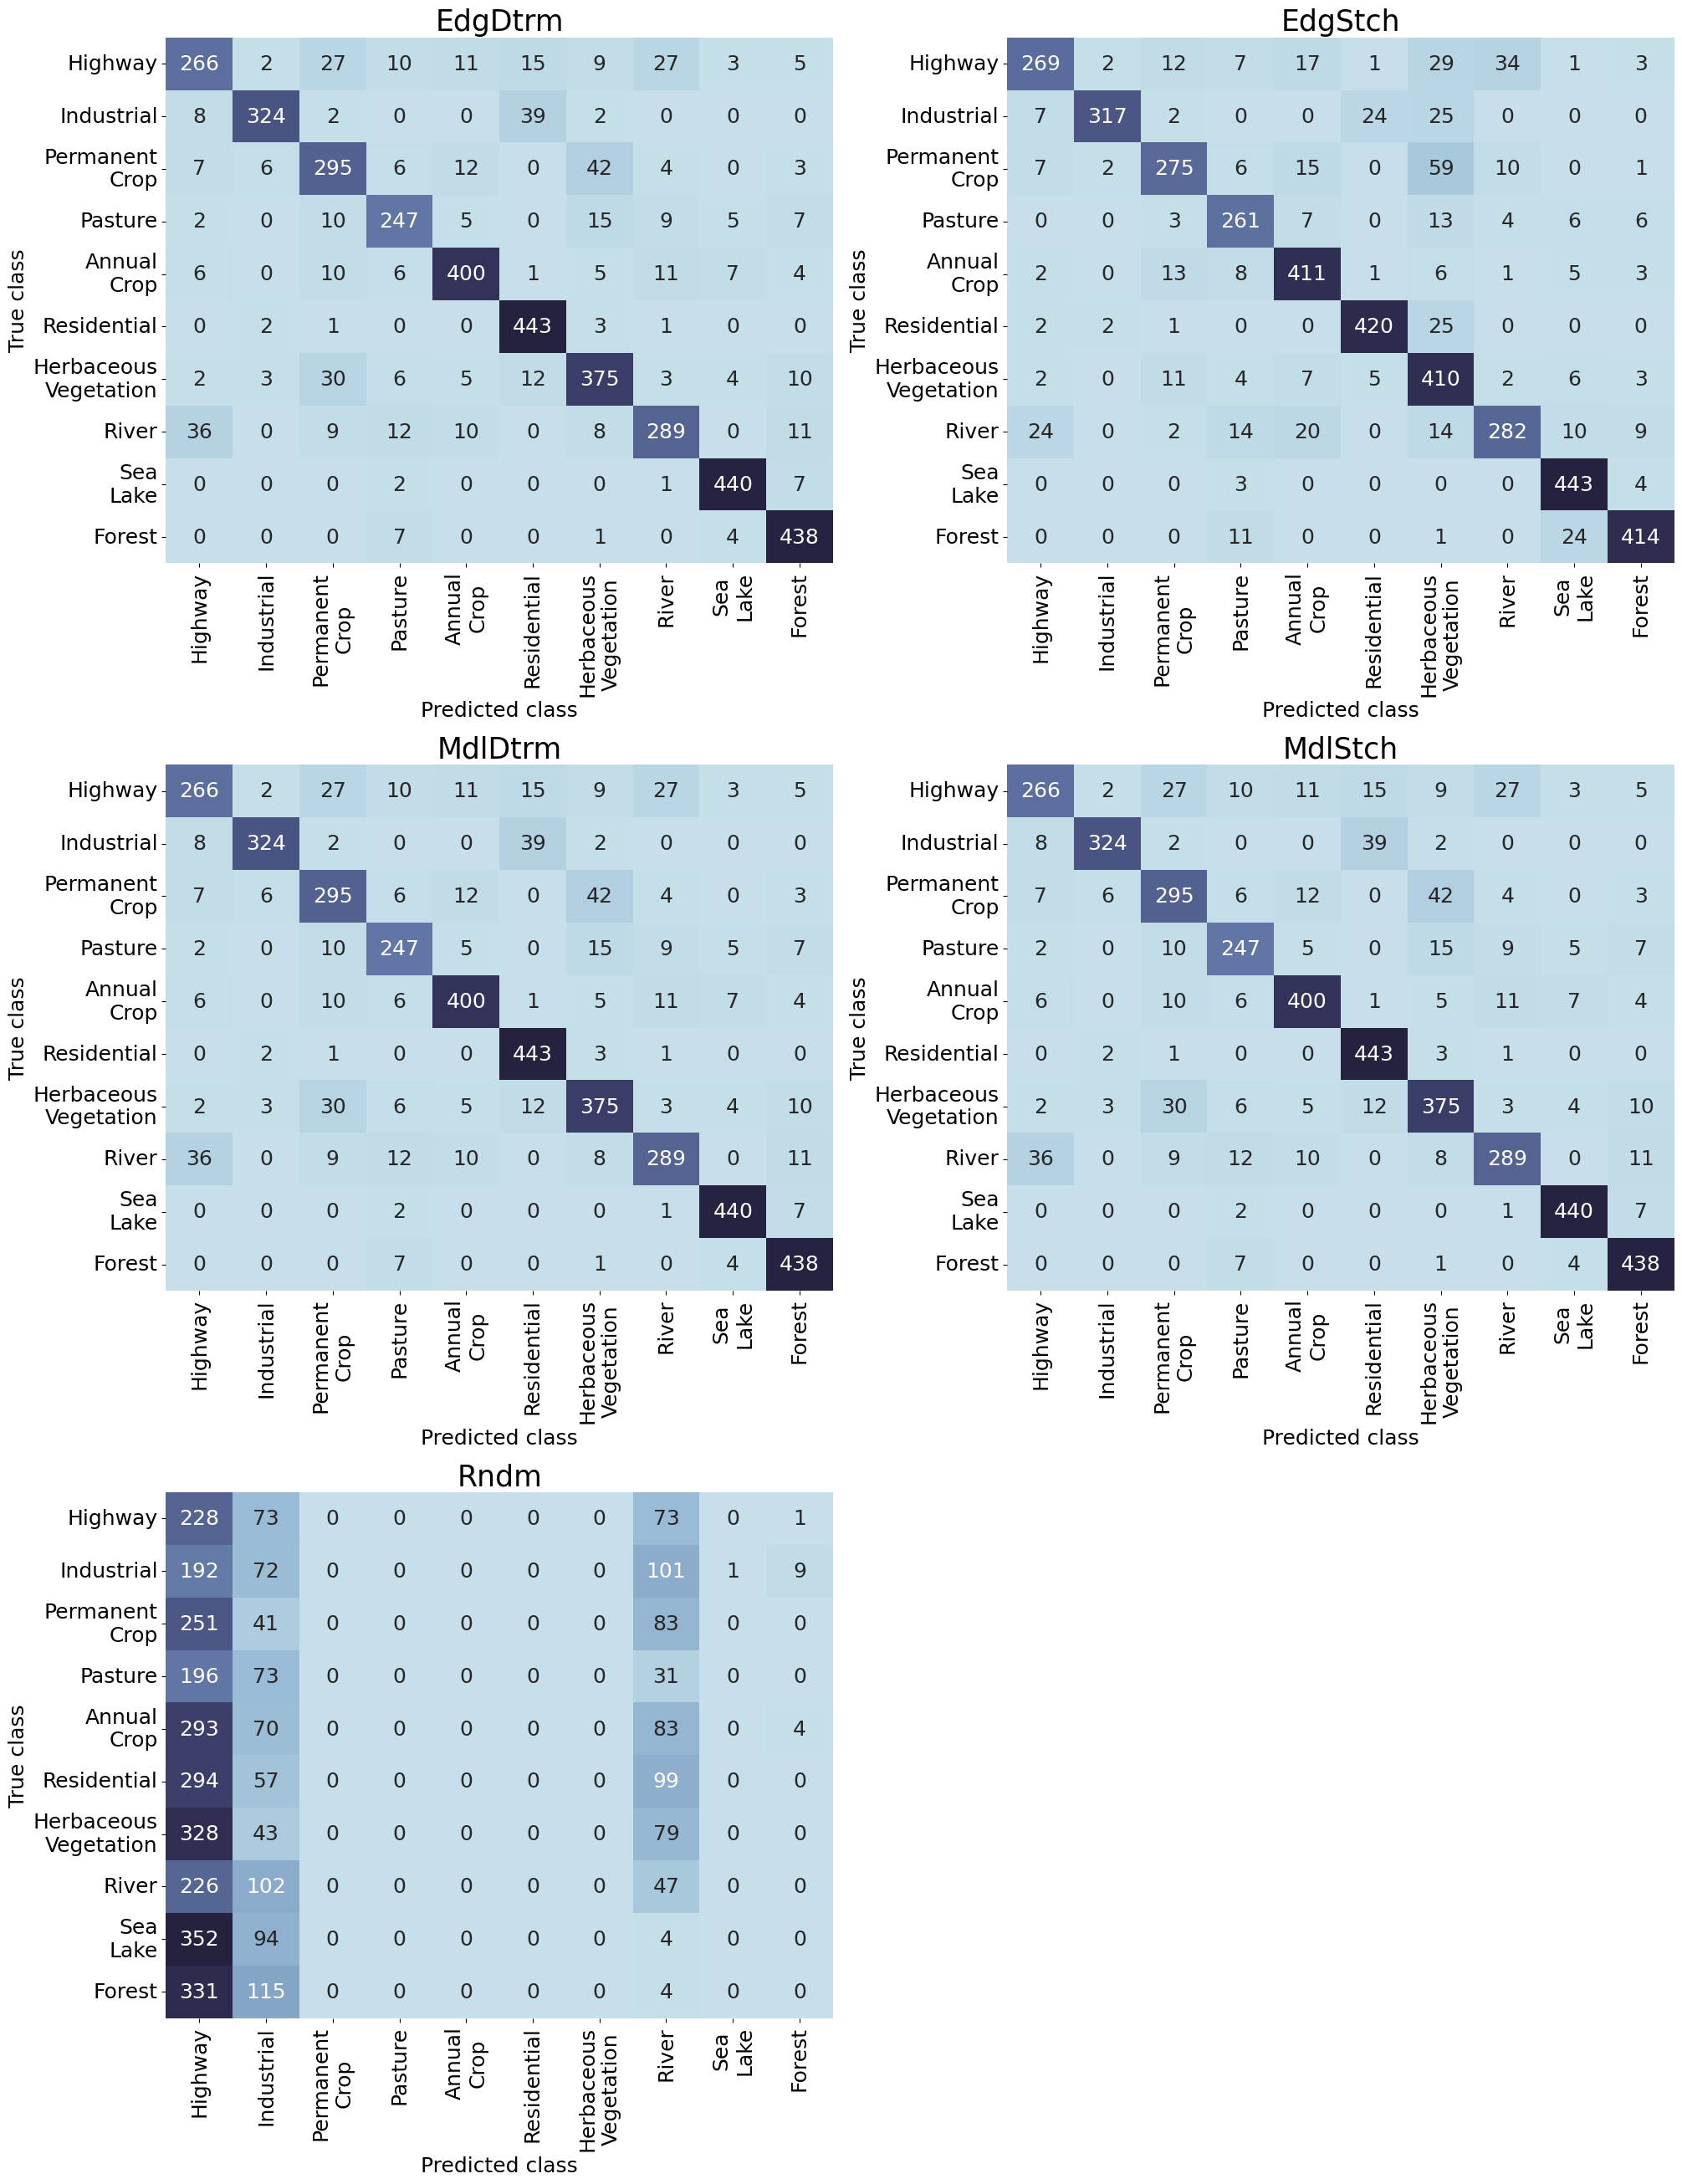

In [284]:
# fig, axs = plt.subplots(ncols=2, figsize=(20, 10), constrained_layout=True)

font_size = 18

plt.figure(figsize=(20, 26), constrained_layout=True)

plt.subplot(321)
sns.heatmap(
    df_cm_edg_fixed, annot=True, xticklabels=df_cm_edg_fixed.columns, yticklabels=df_cm_edg_fixed.columns, 
    cmap=sns.color_palette("ch:start=.1,rot=-.2", as_cmap=True),
    # ax=axs[1],
    cbar=False,
    annot_kws={"size": font_size},
    fmt='g'
)
plt.ylabel("True class", fontsize=font_size)
plt.xlabel("Predicted class", fontsize=font_size)
plt.yticks(fontsize=font_size, rotation=0)
plt.xticks(fontsize=font_size, rotation=90)
plt.title("EdgDtrm", fontsize=25)
# axs[1].tick_params(labelsize=15)


plt.subplot(322)
sns.heatmap(
    df_cm_edg_proba, annot=True, xticklabels=df_cm_edg_proba.columns, yticklabels=df_cm_edg_proba.columns, 
    cmap=sns.color_palette("ch:start=.1,rot=-.2", as_cmap=True),
    # ax=axs[1],
    cbar=False,
    annot_kws={"size": font_size},
    fmt='g'
)
plt.ylabel("True class", fontsize=font_size)
plt.xlabel("Predicted class", fontsize=font_size)
plt.title("EdgStch", fontsize=25)
plt.yticks(fontsize=font_size, rotation=0)
plt.xticks(fontsize=font_size, rotation=90)

plt.subplot(323)
sns.heatmap(
    df_cm_los_fixed, annot=True, xticklabels=df_cm_los_fixed.columns, yticklabels=df_cm_los_fixed.columns, 
    cmap=sns.color_palette("ch:start=.1,rot=-.2", as_cmap=True),
    # ax=axs[1],
    cbar=False,
    annot_kws={"size": font_size},
    fmt='g'
)
plt.ylabel("True class", fontsize=font_size)
plt.xlabel("Predicted class", fontsize=font_size)
plt.title("MdlDtrm", fontsize=25)
plt.yticks(fontsize=font_size, rotation=0)
plt.xticks(fontsize=font_size, rotation=90)


plt.subplot(324)
sns.heatmap(
    df_cm_los_proba, annot=True, xticklabels=df_cm_los_proba.columns, yticklabels=df_cm_los_proba.columns, 
    cmap=sns.color_palette("ch:start=.1,rot=-.2", as_cmap=True),
    # ax=axs[1],
    cbar=False,
    annot_kws={"size": font_size},
    fmt='g'
)
plt.ylabel("True class", fontsize=font_size)
plt.xlabel("Predicted class", fontsize=font_size)
plt.title("MdlStch", fontsize=25)
plt.yticks(fontsize=font_size, rotation=0)
plt.xticks(fontsize=font_size, rotation=90)


plt.subplot(325)
sns.heatmap(
    df_cm_random, annot=True, xticklabels=df_cm_random.columns, yticklabels=df_cm_random.columns, 
    cmap=sns.color_palette("ch:start=.1,rot=-.2", as_cmap=True),
    # ax=axs[1],
    cbar=False,
    annot_kws={"size": font_size},
    fmt='g'
)
plt.ylabel("True class", fontsize=font_size)
plt.xlabel("Predicted class", fontsize=font_size)
plt.title("Rndm", fontsize=25)
plt.yticks(fontsize=font_size, rotation=0)
plt.xticks(fontsize=font_size, rotation=90)

plt.savefig("/Users/dbugajny/Desktop/conf_mat_es.png")